# <u>Tut_9.1</u>

## Learning outcomes

* Fit a deep learning neural network for Regression task
* Save and load tensorflow models (.h5 extension)

---

* Import libraries and units

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import os
import tensorflow as tf;
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
sns.set_style('whitegrid')


### Workflow

* Split the dataset into train, validation and test set
* Create a pipeline to handle data cleaning, feature engineering and feature scaling (as we covered, it is highly recommended the data be scaled, so we wrap up in one pipeline)
* Create the neural network
* Fit the pipeline to the train set and transformations to the other sets
* Fit the model to the train and validation set
* Evaluate the model
* Predict on new data

In [74]:
data = fetch_california_housing()
df = pd.DataFrame(data.data,columns=data.feature_names)
df['price'] = pd.Series(data.target)
print(df.shape)
df.head()


(20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


* Split dataset

In [75]:
# First, we split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
                                    df.drop(['price'],axis=1),
                                    df['price'],
                                    test_size=0.2,
                                    random_state=0
                                    )
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (16512, 8) (16512,) 
* Test set: (4128, 8) (4128,)


In [76]:
# Then, from the train set, we split a validation set. We set the validation set as 20% of the train set
X_train, X_val, y_train, y_val = train_test_split(
                                    X_train,
                                    y_train,
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape)
print("* Validation set:",  X_val.shape, y_val.shape)
print("* Test set:",   X_test.shape, y_test.shape)

* Train set: (13209, 8) (13209,)
* Validation set: (3303, 8) (3303,)
* Test set: (4128, 8) (4128,)


## Pipeline for data processing

* We first create a pipeline for preprocessing the data. In theory, it could handle the processes of data cleaning, feature engineering, feature scaling and removing correlating features. But in this case **pipeline** will only include feature scaling, for simplicity.

In [77]:
def pipeline_pre_processing():
    """
    Define data preparation pipeline
    """
    pipeline_base = Pipeline([

      ( "feat_scaling", StandardScaler() )

    ])
    return pipeline_base

* Fit the pipeline to the train set and transformations to the validation and test set. So the pipeline can learn the transformations (in this case, it is only feature scaling) from the train set and apply the transformation to the other sets.

In [78]:
pipeline = pipeline_pre_processing()
X_train = pipeline.fit_transform(X_train)
X_val= pipeline.transform(X_val)
X_test = pipeline.transform(X_test)

## Create deep learning network

#### We will create a tensorflow model.
* We create a function that creates a sequential model, compiles the model and returns the mode. The function requires the number of features the data has to be used as the number of neurons from the first layer
* Let's define the network architecture (a deep learning neural network since it has two or more hidden layers)
* We noted the dataset has 8 features
* First, we will create a simple network just for a learning experience
* The network is built using Dense layers - fully connected layers
* The input layer has the same number of neurons as the number of columns from the data
*  The activation function is relu
* We parse the input_shape in a tuple, the first value is the number of columns from the data, and you don't need to parse the second since the data is uni-dimensional (an image wouldn't be unidimensional, for example)
* We are using two hidden layers, the first with 8 neurons and the next with 4 neurons. Both will use relu as an activation function.
* After each hidden layer, we have a dropout layer with a 25% rate; so we can reduce the chance of overfitting
* The output layer should contain only 1 neuron since the ML task is Regression
* We compile the model with mse as a loss/cost function and optimizer as adam

In [79]:
def create_tf_model(n_features):

  model = Sequential()
  model.add(Dense(units=n_features, activation='relu', input_shape=(n_features,)))

  model.add(Dense(units=8,activation='relu'))
  model.add(Dropout(0.25))

  model.add(Dense(units=4,activation='relu'))
  model.add(Dropout(0.25))

  model.add(Dense(units=1))
  model.compile(loss='mse', optimizer='adam')

  return model

In [80]:
model = create_tf_model(n_features=X_train.shape[1])
model.summary()

c:\Users\soyak\OneDrive\Documents\m32895\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185 (740.00 B)

 Trainable params: 185 (740.00 B)

 Non-trainable params: 0 (0.00 B)

#### Let's visualize the network structure
* Note the number of parameters the network has. That looks to be a reasonable amount compared to the number of rows the train set has
* A non-reasonable amount would be like 100 thousand parameters for a dataset with 1k. Or maybe your dataset is so tiny and complex, and you need more parameters, but the rule of thumb suggests starting easy and adding more complexity if the performance is not good.

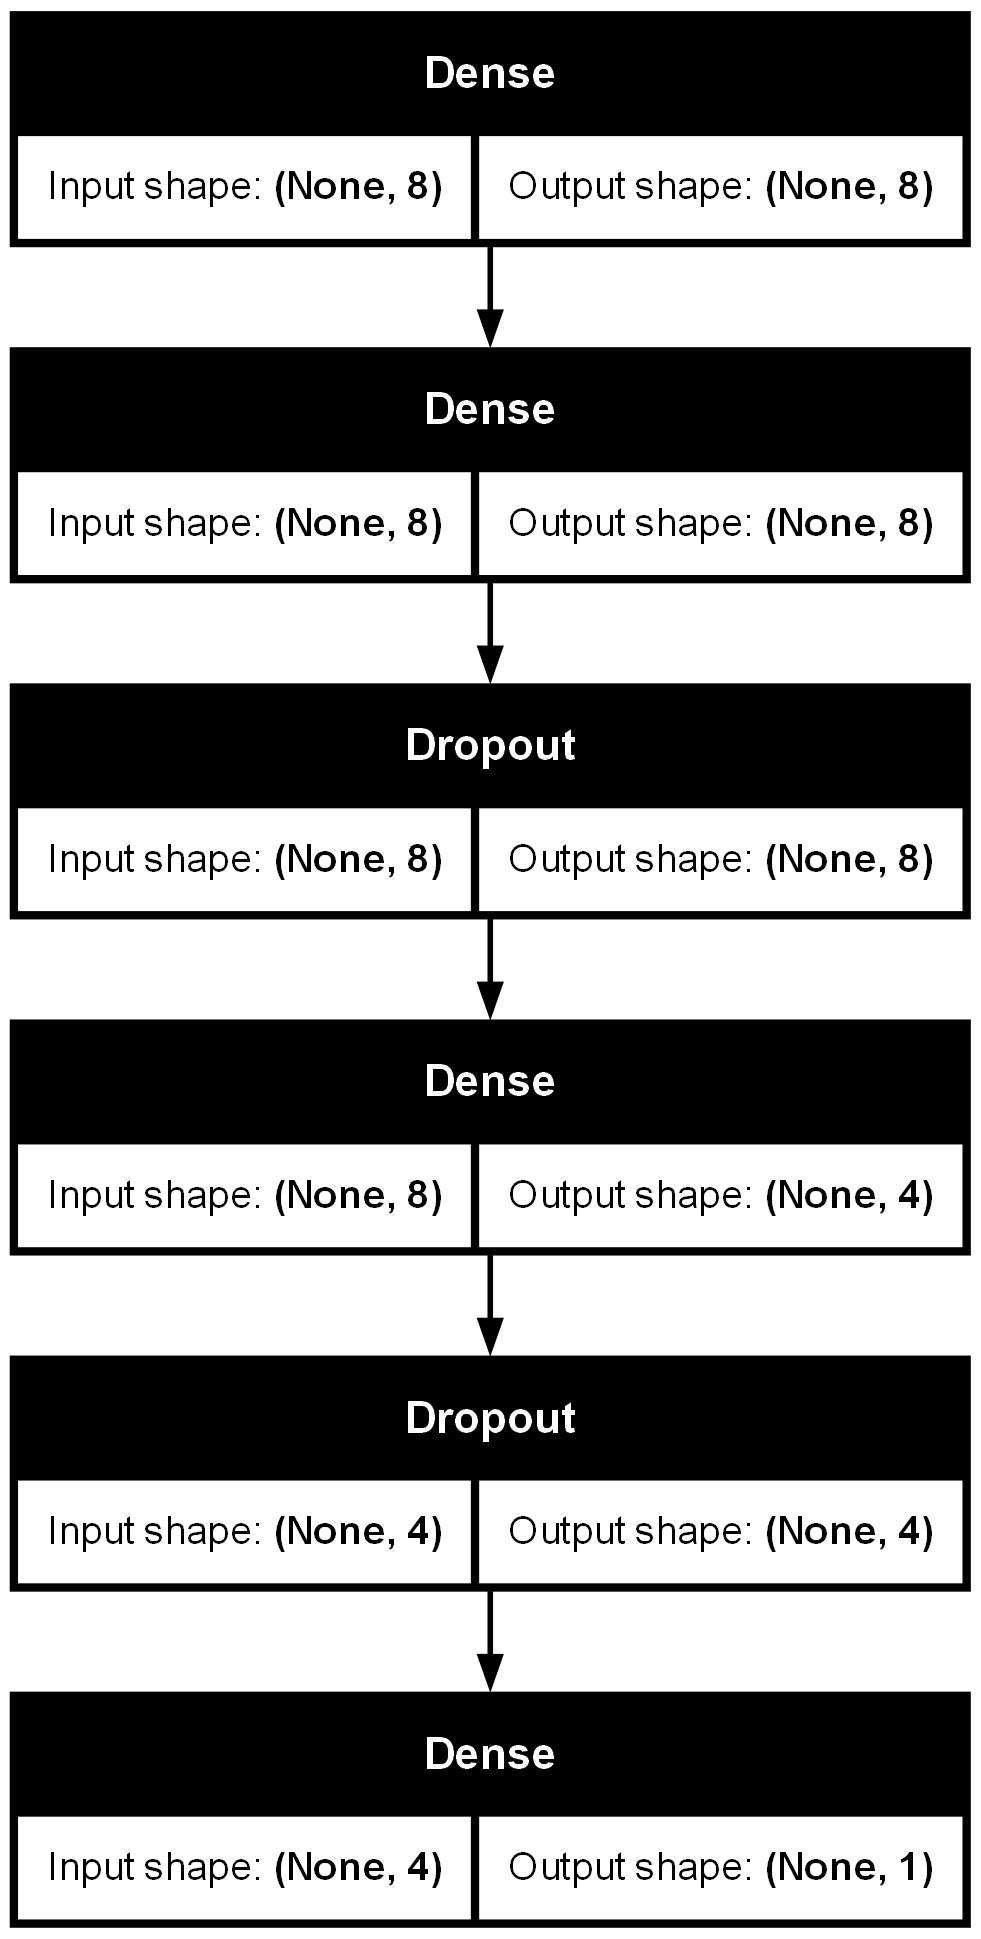

In [137]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='../outputs/models/nn_regression.png')

* Note the input and output shape each layer has. That is how your data is "travelling" from the input to the prediction.

## Fit the model

* Early stopping stops training when a monitored metric has stopped improving; this is useful to avoid overfitting the model to the data
* We will monitor the validation loss
* Remember that now we parse the train and validation data. After a given epoch finishes, the network calculates the error. The training process stops if the validation error doesn't improve for a given set of consecutive epochs
* We set patience as 15, which is the number of epochs with no improvement; after that, training will be stopped. Although there is no fixed rule to set patience, if you feel that your model is still learning, then you stop; you may increase the value and train again
* We set the mode to min. According to TensorFlow documentation, in min mode, training will stop when the quantity monitored has stopped decreasing

In [82]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

#### We will finally fit the model
* We create the model object and use .fit(), as usual
* We parse the Train set
* The epoch is set to 100. In theory, you may set a high value since we will add an early stop, which stops the training process when there is no training improvement
* We parse the validation data in a tuple
* Verbose is set to 1 to see in which epochs we are and the training and validation loss
* Finally, we parse our callback as the early_stop object we created earlier. We parse in a list since you may parse more than 1 type of callback. In this tutorial, we will cover only early stopping, but there are some other options (check TensorFlow documentation)
* For each epoch, note the training and validation loss. Are they increasing? Decreasing? Still?
* Ideally, it should decrease as long as the epoch increases, showing a practical sign the network is learning

In [83]:
model.fit(x=X_train,
          y=y_train,
          epochs=100,
          validation_data=(X_val, y_val),
          verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.0134 - val_loss: 1.2188
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.8810 - val_loss: 0.9642
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.6024 - val_loss: 0.8587
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.2622 - val_loss: 0.7925
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.1734 - val_loss: 0.7179
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.0125 - val_loss: 0.6323
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.8731 - val_loss: 0.5914
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.8026 - val_loss: 0.5489
Epoch 9/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.7685 - val_loss: 0.5410
Epoch 10/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.6957 - val_loss: 0.4983
Epoch 11/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6992 - val_loss: 0.4836
Epoch 12/100
413/413 ━━━━━━━━━━━━━━━━━━━━

## Model evaluation

* Now we will evaluate the model performance by analyzing the training and validation losses that happened during the training process
* In deep learning, we use the model history to assess if the model learned, using the train and validation sets
* We also evaluate separately how the model generalises on unseen data (on the test set)
* The model training history information is stored in a .history.history attribute. Note it shows a loss (training loss) and val_loss (validation_loss)

In [84]:
losses = pd.DataFrame(model.history.history)
losses

,loss,val_loss
0,3.006012,1.218762
1,1.812852,0.964200
2,1.495045,0.858676
3,1.239984,0.792478
4,1.144350,0.717875
...,...,...
61,0.548402,0.403163
62,0.544043,0.390276
63,0.543678,0.386908
64,0.546572,0.403185


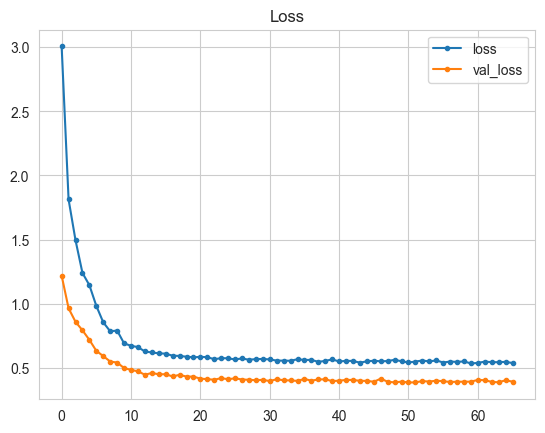

In [85]:
sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.show()

* Next, we will evaluate the model performance on the test set, using .evaluate() and parsing the test set
* Note the value is not much different from the losses in the train and validation set
* Note the model learned the relationship between the features and the target, considering all features
* Conventional ML often use a feature selection step to remove features that wouldn't contribute to the model learning, thus increasing the chance of overfitting the model
* But in **Deep Learning**, the neural network handles this topic by itself. The connections related to less important features are weaker after the training process; therefore, it doesn't harm the overall performance

In [86]:
model.evaluate(X_test,y_test)

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3930


0.37878137826919556

* When evaluating a deep learning model, you typically cover the loss plot and evaluate the test set; however, you can do, if you want, as an additional step, a similar evaluation we did in conventional ML
* In regression, you would analyse the performance metrics and actual x predictions plot using the custom function we have seen over the course

In [ ]:
def regression_performance(X_train, y_train,
                           X_val, y_val,
                           X_test, y_test,pipeline):
    """
    Assessment of performance of CNN regression model
    """
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train,y_train,pipeline)
    print("* Validation Set")
    regression_evaluation(X_val, y_val,pipeline)
    print("* Test Set")
    regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X, y, pipeline):
    """
    Gets features and target (either from train or test set) and pipeline.
    - Predicts using the pipeline and the features
    - Calculates performance metrics comparing the prediction to the target
    """
    prediction = pipeline.predict(X)
    print('R2 Score:', round(r2_score(y, prediction), 3))
    print('Mean Absolute Error:', round(mean_absolute_error(y, prediction), 3))
    print('Mean Squared Error:', round(mean_squared_error(y, prediction), 3))
    print('Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y, prediction)), 3))
    print("\n")
    

def regression_evaluation_plots(X_train, y_train,
                                X_val, y_val,
                                X_test, y_test,
                                pipeline, alpha_scatter=0.5):
    """
    Plot regression evaluation
    """
    pred_train = pipeline.predict(X_train).reshape(-1)
    # we reshape the prediction arrays to be in the format (n_rows,), so we can plot it after
    pred_val = pipeline.predict(X_val).reshape(-1)
    pred_test = pipeline.predict(X_test).reshape(-1)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,6))
    
    sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
    
    sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")
    
    sns.scatterplot(x=y_val , y=pred_val, alpha=alpha_scatter, ax=axes[1])
    
    sns.lineplot(x=y_val , y=y_val, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Validation Set")
    
    sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[2])
    sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[2])
    axes[2].set_xlabel("Actual")
    axes[2].set_ylabel("Predictions")
    axes[2].set_title("Test Set")
    
    plt.show()

* Let's parse the values as usual
* Note here we don't parse a pipeline; we use the TensorFlow model
* Note the predictions tend to follow the red diagonal line. However, it seems the test set metrics are quite different from the train/validation set. You could add more complexity to the model or increase the number of epochs etc until you reach a metric that can satisfy you. For learning purposes, we will be happy with this performance
* In general, we would expect the performance to be better in the train set, validation, and test set. However, there may be cases where this doesn't happen

Model Evaluation 

* Train Set
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
R2 Score: 0.719
Mean Absolute Error: 0.455
Mean Squared Error: 0.376
Root Mean Squared Error: 0.614


* Validation Set
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R2 Score: 0.706
Mean Absolute Error: 0.464
Mean Squared Error: 0.392
Root Mean Squared Error: 0.626


* Test Set
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R2 Score: 0.71
Mean Absolute Error: 0.459
Mean Squared Error: 0.379
Root Mean Squared Error: 0.615


413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


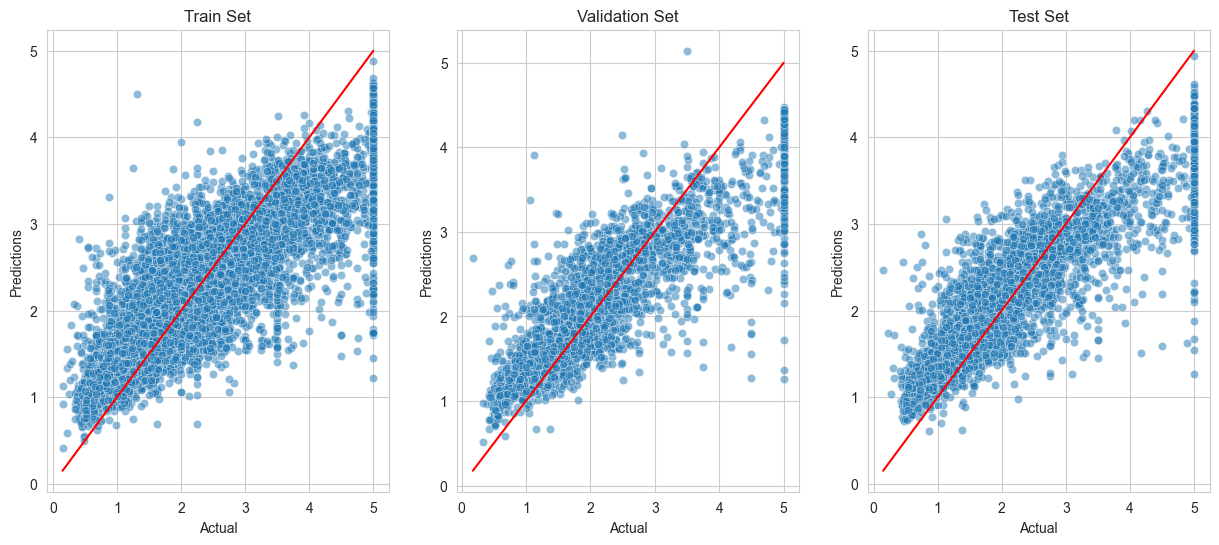

In [88]:
regression_performance(X_train, y_train,X_val, y_val, X_test, y_test,model)
regression_evaluation_plots(X_train, y_train, X_val, y_val,X_test, y_test,
                            model, alpha_scatter=0.5)

## Prediction

In [89]:
X_test.shape

(4128, 8)

In [111]:
live_data = X_test[54:55,:]
live_data

array([[-1.2449854 , -0.20116759, -1.69946574, -0.09213495, -0.2003886 ,
         0.14367436, -0.73320429,  0.64473104]])

* We use .predict() and parse the data. In this case, we are predicting the price of 2 houses
* Since the X_test data is scaled and is an array, it is difficult to make sense of the content, but we are assuming here the data has passed through the pre_processing pipeline already

In [112]:
model.predict(live_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


array([[1.7800776]], dtype=float32)

---

In [122]:
sample = pd.DataFrame({
    'MedInc': [8.325200],
    'HouseAge': [41.000000],
    'AveRooms': [6.984127],
    'AveBedrms': [1.023810],
    'Population': [322.000000],
    'AveOccup': [2.555556],
    'Latitude': [37.880000],
    'Longitude': [-122.230000] 
})

sample


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.02381,322.0,2.555556,37.88,-122.23


In [124]:
sample_cnn = pipeline.transform(sample.values)
sample_cnn


c:\Users\soyak\OneDrive\Documents\m32895\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[ 2.33427752,  0.99158883,  0.69465782, -0.1578881 , -0.98629534,
        -0.08184656,  1.04783331, -1.3256435 ]])

In [ ]:
predicted_price = model.predict(sample_cnn)[0][0]
print('---------------')
print(f"Predicted house price based on the information provided is: {predicted_price:.2f} arb. units.")
print('---------------')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
---------------
Predicted house price based on the information provided is 3.62 arb. units.
---------------


## Save and load the Model

In [136]:
model.save('../outputs/models/nn_regression.h5')